<a href="https://colab.research.google.com/github/alecinvan/Colab_AI_tutorial/blob/main/ForeignObjectDetectionSubwayTracks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<font color="blue" size="7">**地铁/轨道交通隧道摄像机的异物检测**。<br>

<font color="darkblue" size="4">一套完整 pipeline，你在 Colab 里一键跑完能得到定量指标（mAP、Precision/Recall/F1、误报率、延迟）和可视化结果（GT 和预测框对比）<br>


<font color="darkred" size="5">*Alec作品*<br>


<font color="darkgreen" size="5">**- 安装依赖 + 固定随机种子**<br>

In [ ]:
!pip -q install ultralytics opencv-python pillow matplotlib tqdm pyyaml

import os, random, math, time, json
from pathlib import Path
import numpy as np
import cv2
from PIL import Image, ImageEnhance, ImageFilter
import matplotlib.pyplot as plt
from tqdm import tqdm

random.seed(42)
np.random.seed(42)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 79.5 MB/s eta 0:00:00


<font color="darkgreen" size="5">**- 下载公开背景图 + 异物 PNG（透明通道）**<br>

In [ ]:
import urllib.request
import urllib.error # Import urllib.error to catch specific HTTPError

ROOT = Path("/content/rail_foreign_object_exp")
ASSETS_BG = ROOT/"assets/backgrounds"
ASSETS_OBJ = ROOT/"assets/objects"
ASSETS_BG.mkdir(parents=True, exist_ok=True)
ASSETS_OBJ.mkdir(parents=True, exist_ok=True)

# Wikimedia Commons 背景（隧道/轨道）
BACKGROUND_URLS = {
    "subway_tunnel_1": "https://commons.wikimedia.org/wiki/Special:FilePath/Subway_tunnel.JPG",
    "taipei_orange": "https://commons.wikimedia.org/wiki/Special:FilePath/Tunnel_and_track_of_Taipei_metro_orange_line_at_the_north_side_of_Guting_Station.JPG",
    "ttc_museum": "https://commons.wikimedia.org/wiki/Special:FilePath/Museum_TTC_tunnel_nb_in.jpg",
    "subway_train_tunnel": "https://commons.wikimedia.org/wiki/Special:FilePath/Subway%20Train%20Tunnel.JPG",
    "muni_church": "https://commons.wikimedia.org/wiki/Special:FilePath/Muni_Metro_tunnel_near_Church_Street_portal%2C_May_2010.jpg",
    "minsk_portal": "https://commons.wikimedia.org/wiki/Special:FilePath/Kavalskaja_slabada_%28Minsk_Metro_station%29_-_track_and_tunnel_portal.jpg",
}

# OpenClipart 异物 PNG（透明背景）
OBJECT_URLS = {
    "bag": "https://openclipart.org/image/2000px/303136",
    "cone": "https://openclipart.org/image/2000px/281246",
    "bottle": "https://openclipart.org/image/2000px/293067",
    "suitcase": "https://openclipart.org/image/2000px/301754",
    "box": "https://openclipart.org/image/2000px/351509",
}

def download(url, out_path):
    if out_path.exists():
        print(f"File already exists: {out_path.name}")
        return
    # Add a User-Agent header to mimic a browser request
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
    req = urllib.request.Request(url, headers=headers)
    try:
        # Use urlopen to get the response, then save content
        with urllib.request.urlopen(req) as response:
            with open(out_path, 'wb') as out_file:
                out_file.write(response.read())
        print(f"Downloaded {out_path.name} from {url}")
    except urllib.error.HTTPError as e:
        print(f"HTTP Error {e.code} for {out_path.name}: {e.reason}")
    except Exception as e:
        print(f"Error downloading {out_path.name} from {url}: {e}")

for k,u in BACKGROUND_URLS.items():
    download(u, ASSETS_BG/f"{k}.jpg")

for k,u in OBJECT_URLS.items():
    download(u, ASSETS_OBJ/f"{k}.png")

print("Backgrounds:", len(list(ASSETS_BG.glob("*.jpg"))))
print("Objects:", len(list(ASSETS_OBJ.glob("*.png"))))

File already exists: subway_tunnel_1.jpg
File already exists: taipei_orange.jpg
File already exists: ttc_museum.jpg
File already exists: subway_train_tunnel.jpg
File already exists: muni_church.jpg
File already exists: minsk_portal.jpg
File already exists: bag.png
File already exists: cone.png
File already exists: bottle.png
File already exists: suitcase.png
File already exists: box.png
Backgrounds: 6
Objects: 5


<font color="darkgreen" size="5">**- 合成数据集（科研关键）Copy-Paste + YOLO 标注）**<br>

可控的数据生成 + domain split + 自动标注。

In [ ]:
DATA = ROOT/"dataset"
for split in ["train","val","test"]:
    (DATA/f"images/{split}").mkdir(parents=True, exist_ok=True)
    (DATA/f"labels/{split}").mkdir(parents=True, exist_ok=True)

CLASS_NAMES = ["bag","cone","bottle","suitcase","box"]
name2id = {n:i for i,n in enumerate(CLASS_NAMES)}

bg_paths = sorted(list(ASSETS_BG.glob("*.jpg")))
obj_paths = {p.stem: p for p in ASSETS_OBJ.glob("*.png")}

# 训练/测试背景做 domain split（更科研：测试用不同背景）
train_bgs = bg_paths[:4]
test_bgs  = bg_paths[4:]

def load_rgba(path):
    img = Image.open(path).convert("RGBA")
    return img

def roi_trapezoid(w,h):
    # 轨行区粗略梯形：上窄下宽（可按你们相机标定改成真实多边形）
    return np.array([
        [0.35*w, 0.55*h],
        [0.65*w, 0.55*h],
        [0.95*w, 0.98*h],
        [0.05*w, 0.98*h],
    ], dtype=np.float32)

def sample_point_in_roi(w,h):
    pts = roi_trapezoid(w,h)
    y_top, y_bot = pts[0,1], pts[2,1]
    t = random.random()
    y = y_top + t*(y_bot - y_top)
    # 左右边线性插值
    left_x  = (1-t)*pts[0,0] + t*pts[3,0]
    right_x = (1-t)*pts[1,0] + t*pts[2,0]
    x = left_x + random.random()*(right_x-left_x)
    return int(x), int(y), t

def paste_object(bg_rgba, obj_rgba, cx, cy, scale, angle):
    obj = obj_rgba.copy()

    # resize
    ow, oh = obj.size
    nw, nh = max(10,int(ow*scale)), max(10,int(oh*scale))
    obj = obj.resize((nw,nh), Image.BICUBIC)

    # rotate
    obj = obj.rotate(angle, expand=True, resample=Image.BICUBIC)

    # bbox from alpha
    arr = np.array(obj)
    alpha = arr[:,:,3]
    ys, xs = np.where(alpha > 10)
    if len(xs)==0:
        return bg_rgba, None
    x0, x1 = xs.min(), xs.max()
    y0, y1 = ys.min(), ys.max()

    # paste position (top-left)
    pw, ph = obj.size
    x = int(cx - pw/2)
    y = int(cy - ph/2)

    # paste
    bg_rgba.alpha_composite(obj, (x,y))

    # bbox in bg coords (clip)
    bx0 = max(0, x + x0); by0 = max(0, y + y0)
    bx1 = min(bg_rgba.size[0]-1, x + x1); by1 = min(bg_rgba.size[1]-1, y + y1)
    if bx1<=bx0 or by1<=by0:
        return bg_rgba, None
    return bg_rgba, (bx0, by0, bx1, by1)

def photometric_aug(img_rgb):
    img = img_rgb
    # brightness/contrast
    img = ImageEnhance.Brightness(img).enhance(random.uniform(0.75, 1.25))
    img = ImageEnhance.Contrast(img).enhance(random.uniform(0.75, 1.25))
    # blur
    if random.random() < 0.35:
        img = img.filter(ImageFilter.GaussianBlur(radius=random.uniform(0.2, 1.2)))
    return img

def add_noise_cv(img_bgr):
    if random.random() < 0.35:
        noise = np.random.normal(0, random.uniform(3,10), img_bgr.shape).astype(np.float32)
        out = np.clip(img_bgr.astype(np.float32) + noise, 0, 255).astype(np.uint8)
        return out
    return img_bgr

def to_yolo_bbox(bx0,by0,bx1,by1,w,h):
    cx = (bx0+bx1)/2.0 / w
    cy = (by0+by1)/2.0 / h
    bw = (bx1-bx0) / w
    bh = (by1-by0) / h
    return cx,cy,bw,bh

def gen_split(split, n_images, bg_list, empty_ratio=0.35):
    manifest = []
    for i in tqdm(range(n_images), desc=f"Gen {split}"):
        bg_path = random.choice(bg_list)
        bg = Image.open(bg_path).convert("RGB")
        # 统一尺寸（可按你们相机分辨率改）
        bg = bg.resize((1280, 720), Image.BICUBIC)

        clean_bg = bg.copy()  # 给传统基线用的“背景模板”
        bg_rgba = bg.convert("RGBA")

        labels = []
        make_empty = (random.random() < empty_ratio)

        if not make_empty:
            k = 1 if random.random()<0.75 else 2
            for _ in range(k):
                cls = random.choice(CLASS_NAMES)
                obj = load_rgba(obj_paths[cls])

                w,h = bg_rgba.size
                cx, cy, t = sample_point_in_roi(w,h)

                # 远处小、近处大（t越大越靠近底部）
                base = 0.10 + 0.22*t
                scale = random.uniform(base*0.7, base*1.3)

                angle = random.uniform(-15, 15)
                bg_rgba, bbox = paste_object(bg_rgba, obj, cx, cy, scale, angle)
                if bbox:
                    cxn,cyn,bwn,bhn = to_yolo_bbox(*bbox, w,h)
                    labels.append((name2id[cls], cxn,cyn,bwn,bhn))

        out_img = bg_rgba.convert("RGB")
        out_img = photometric_aug(out_img)
        img_bgr = cv2.cvtColor(np.array(out_img), cv2.COLOR_RGB2BGR)
        img_bgr = add_noise_cv(img_bgr)
        out_img = Image.fromarray(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))

        img_name = f"{split}_{i:04d}.jpg"
        lbl_name = f"{split}_{i:04d}.txt"
        out_img.save(DATA/f"images/{split}/{img_name}", quality=92)

        with open(DATA/f"labels/{split}/{lbl_name}", "w") as f:
            for (cid,cx,cy,bw,bh) in labels:
                f.write(f"{cid} {cx:.6f} {cy:.6f} {bw:.6f} {bh:.6f}\n")

        # 保存 clean_bg 供传统基线差分用（按背景名存一份）
        clean_bg_path = ROOT/"clean_backgrounds"/bg_path.name
        clean_bg_path.parent.mkdir(parents=True, exist_ok=True)
        if not clean_bg_path.exists():
            clean_bg.save(clean_bg_path, quality=95)

        manifest.append({
            "img": img_name,
            "bg": bg_path.name,
            "has_obj": (len(labels)>0),
            "n_obj": len(labels),
        })

    # manifest
    import csv
    with open(ROOT/f"manifest_{split}.csv", "w", newline="") as f:
        w = csv.DictWriter(f, fieldnames=["img","bg","has_obj","n_obj"])
        w.writeheader()
        w.writerows(manifest)

# 规模别太大，保证 Colab 快速跑完；你们后续可放大
gen_split("train", n_images=500, bg_list=train_bgs, empty_ratio=0.40)
gen_split("val",   n_images=120, bg_list=train_bgs, empty_ratio=0.40)
gen_split("test",  n_images=160, bg_list=test_bgs,  empty_ratio=0.50)

print("Done.")


Gen test: 100%|██████████| 160/160 [00:35<00:00,  4.46it/s]

Done.


<font color="darkgreen" size="5">**- 生成 data.yaml（Ultralytics 数据入口）**<br>

*   Ultralytics 用 data.yaml 读取数据路径和类别名。
*   names 映射 id→类别名，预测可视化时会用到。



In [ ]:
import yaml

data_yaml = {
    "path": str(DATA),
    "train": "images/train",
    "val": "images/val",
    "test": "images/test",
    "names": {i:n for i,n in enumerate(CLASS_NAMES)}
}
with open(ROOT/"data.yaml", "w") as f:
    yaml.safe_dump(data_yaml, f, sort_keys=False)

print((ROOT/"data.yaml").read_text())


path: /content/rail_foreign_object_exp/dataset
train: images/train
val: images/val
test: images/test
names:
  0: bag
  1: cone
  2: bottle
  3: suitcase
  4: box



<font color="darkgreen" size="5">**- 用深度学习去训练** YOLOv8 <br>

*   展示训练日志（loss下降、mAP上升）
*   展示 runs/train/ 下的结果图（PR 曲线、confusion matrix 等）





In [ ]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")  # 轻量，便于实时；你也可换 yolov8s.pt

results = model.train(
    data=str(ROOT/"data.yaml"),
    epochs=25,
    imgsz=640,
    batch=16,
    patience=10,
    cos_lr=True,
    workers=2,
    device=0
)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.4.6 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/rail_foreign_object_exp/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=Fals

<font color="darkgreen" size="5">**- 测试集评估（mAP 等）**  <br>

In [ ]:
metrics = model.val(data=str(ROOT/"data.yaml"), split="test", imgsz=640)
print(metrics)


Ultralytics 8.4.6 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 73 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1927.0±797.0 MB/s, size: 213.9 KB)
val: Scanning /content/rail_foreign_object_exp/dataset/labels/test... 160 images, 84 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 160/160 2.6Kit/s 0.1s
val: New cache created: /content/rail_foreign_object_exp/dataset/labels/test.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 2.4it/s 4.1s
                   all        160         94      0.983      0.946      0.955      0.893
                   bag         19         19      0.985          1      0.995      0.961
                  cone         18         20      0.969        0.9      0.897      0.832
                bottle         19         19          1      0.992      0.995      0.945
              suitcase         19      

<font color="darkgreen" size="5">**- 工具函数（IoU/ROI/解析 label/画框）**  <br>

In [ ]:
def iou_xyxy(a,b):
    ax0,ay0,ax1,ay1 = a
    bx0,by0,bx1,by1 = b
    ix0,iy0 = max(ax0,bx0), max(ay0,by0)
    ix1,iy1 = min(ax1,bx1), min(ay1,by1)
    iw,ih = max(0,ix1-ix0), max(0,iy1-iy0)
    inter = iw*ih
    area_a = max(0,ax1-ax0)*max(0,ay1-ay0)
    area_b = max(0,bx1-bx0)*max(0,by1-by0)
    union = area_a + area_b - inter + 1e-9
    return inter/union

def roi_poly(w,h):
    return roi_trapezoid(w,h).astype(np.int32)

def point_in_roi(x,y,w,h):
    poly = roi_poly(w,h)
    return cv2.pointPolygonTest(poly, (float(x),float(y)), False) >= 0

def yolo_labels_to_boxes(lbl_path, w, h):
    boxes=[]
    with open(lbl_path, "r") as f:
        for line in f:
            parts=line.strip().split()
            if len(parts)!=5: continue
            cid,cx,cy,bw,bh = int(parts[0]), *map(float, parts[1:])
            x0 = int((cx-bw/2)*w); x1 = int((cx+bw/2)*w)
            y0 = int((cy-bh/2)*h); y1 = int((cy+bh/2)*h)
            boxes.append((cid, (x0,y0,x1,y1)))
    return boxes

def draw_boxes(img_bgr, boxes, names, color=(0,255,0), thickness=2):
    out = img_bgr.copy()
    for cid, (x0,y0,x1,y1), conf in boxes:
        cv2.rectangle(out, (x0,y0), (x1,y1), color, thickness)
        label = f"{names[cid]} {conf:.2f}"
        cv2.putText(out, label, (x0, max(0,y0-6)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2, cv2.LINE_AA)
    return out


<font color="darkgreen" size="5">**- 两种方法预测实现（Baseline vs YOLO）**  <br>

In [ ]:
import pandas as pd

MANIFEST_TEST = pd.read_csv(ROOT/"manifest_test.csv")
CLEAN_BG_DIR = ROOT/"clean_backgrounds"

def baseline_bg_subtraction(img_path, bg_path, roi_gate=True):
    img = cv2.imread(str(img_path))
    bg  = cv2.imread(str(bg_path))
    h,w = img.shape[:2]

    diff = cv2.absdiff(img, bg)
    gray = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    _,th = cv2.threshold(gray, 25, 255, cv2.THRESH_BINARY)

    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
    th = cv2.morphologyEx(th, cv2.MORPH_OPEN, k, iterations=2)
    th = cv2.dilate(th, k, iterations=2)

    cnts,_ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boxes=[]
    for c in cnts:
        area = cv2.contourArea(c)
        if area < 700:  # 过滤小噪声
            continue
        x,y,wc,hc = cv2.boundingRect(c)
        cx,cy = x+wc//2, y+hc//2
        if roi_gate and (not point_in_roi(cx,cy,img.shape[1],img.shape[0])):
            continue
        boxes.append((0,(x,y,x+wc,y+hc), 1.0))  # baseline 不分多类，统一当“异物”
    return boxes

def yolo_predict(img_path, conf=0.25, roi_gate=True):
    img = cv2.imread(str(img_path))
    h,w = img.shape[:2]
    t0 = time.perf_counter()
    preds = model.predict(str(img_path), imgsz=640, conf=conf, verbose=False)[0]
    t1 = time.perf_counter()

    boxes=[]
    for b in preds.boxes:
        cid = int(b.cls.item())
        confv = float(b.conf.item())
        x0,y0,x1,y1 = map(int, b.xyxy[0].tolist())
        cx,cy = (x0+x1)//2, (y0+y1)//2
        if roi_gate and (not point_in_roi(cx,cy,w,h)):
            continue
        boxes.append((cid,(x0,y0,x1,y1), confv))
    return boxes, (t1-t0)*1000.0


<font color="darkgreen" size="5">**- 定量对比（TP/FP/FN、F1、空场景误报率、延迟）**  <br>


In [ ]:
def eval_method(method_name, conf=0.25, roi_gate=True):
    tp=fp=fn=0
    empty_fp=0
    lat_ms=[]
    for _,row in MANIFEST_TEST.iterrows():
        img_path = DATA/"images/test"/row["img"]
        img = cv2.imread(str(img_path))
        h,w = img.shape[:2]

        gt = yolo_labels_to_boxes(DATA/"labels/test"/row["img"].replace(".jpg",".txt"), w,h)
        gt_boxes = [b for _,b in gt]

        if method_name=="baseline":
            bg_path = CLEAN_BG_DIR/row["bg"]
            t0=time.perf_counter()
            pred = baseline_bg_subtraction(img_path, bg_path, roi_gate=roi_gate)
            t1=time.perf_counter()
            lat_ms.append((t1-t0)*1000.0)
            pred_boxes = [b for _,b,_ in pred]
        elif method_name=="yolo":
            pred, ms = yolo_predict(img_path, conf=conf, roi_gate=roi_gate)
            lat_ms.append(ms)
            pred_boxes = [b for _,b,_ in pred]
        else:
            raise ValueError("unknown")

        matched_gt=set()
        for pb in pred_boxes:
            best_iou=0; best_j=-1
            for j,gb in enumerate(gt_boxes):
                if j in matched_gt:
                    continue
                v=iou_xyxy(pb,gb)
                if v>best_iou:
                    best_iou=v; best_j=j
            if best_iou>=0.5:
                tp += 1
                matched_gt.add(best_j)
            else:
                fp += 1

        fn += (len(gt_boxes)-len(matched_gt))

        if (row["has_obj"]==False) and (len(pred_boxes)>0):
            empty_fp += 1

    prec = tp/(tp+fp+1e-9)
    rec  = tp/(tp+fn+1e-9)
    f1   = 2*prec*rec/(prec+rec+1e-9)
    far  = empty_fp / max(1, MANIFEST_TEST["has_obj"].eq(False).sum())
    return {
        "method": method_name,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "false_alarm_rate_on_empty": far,
        "latency_ms_avg": float(np.mean(lat_ms))
    }

r_base = eval_method("baseline", roi_gate=True)
r_yolo = eval_method("yolo", conf=0.25, roi_gate=True)

import pandas as pd
df = pd.DataFrame([r_base, r_yolo])
df


,method,precision,recall,f1,false_alarm_rate_on_empty,latency_ms_avg
0,baseline,0.228000,0.606383,0.331395,0.285714,15.882508
1,yolo,0.986667,0.787234,0.875740,0.000000,15.224519


<font color="darkgreen" size="5">**- 打印原图**  <br>

Total clean backgrounds: 6


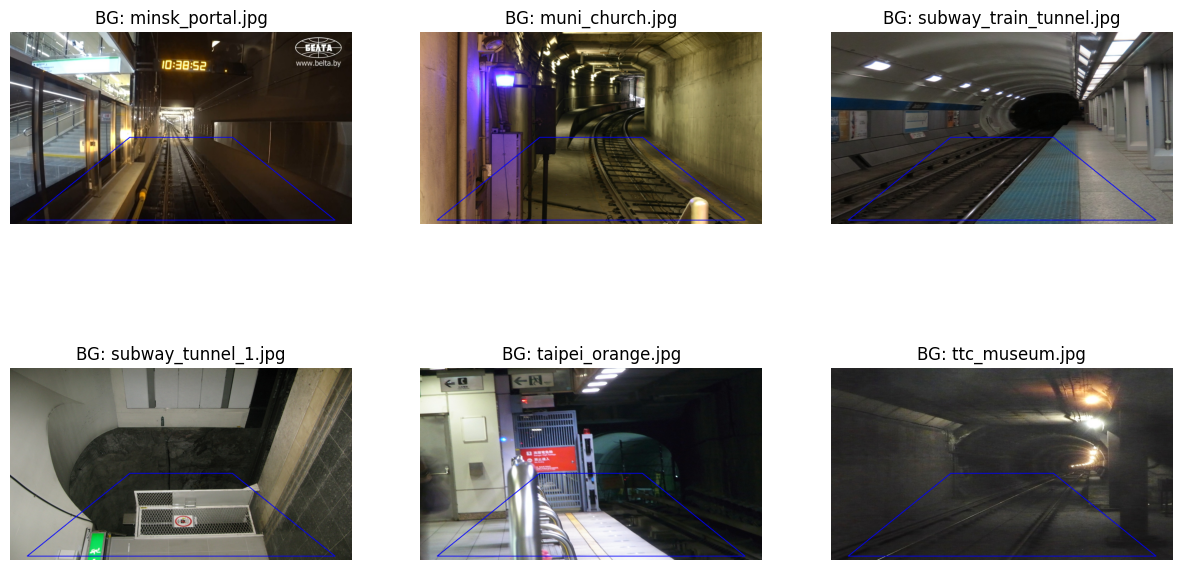

In [ ]:
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
import numpy as np

# 这里用你之前保存的 clean_backgrounds（已resize到 1280x720 的纯背景）
CLEAN_BG_DIR = ROOT/"clean_backgrounds"
bg_list = sorted(list(CLEAN_BG_DIR.glob("*.jpg")))

def roi_poly(w,h):
    # 复用你之前定义的 roi_trapezoid，如果你已经有 roi_poly 可删掉本函数
    pts = np.array([
        [0.35*w, 0.55*h],
        [0.65*w, 0.55*h],
        [0.95*w, 0.98*h],
        [0.05*w, 0.98*h],
    ], dtype=np.int32)
    return pts

def show_images_paged(paths, title_prefix="", cols=3, start=0, n=9, draw_roi=True):
    paths = paths[start:start+n]
    if len(paths)==0:
        print("No images to show.")
        return
    rows = int(np.ceil(len(paths)/cols))
    plt.figure(figsize=(5*cols, 4*rows))
    for i,p in enumerate(paths):
        img = cv2.imread(str(p))
        h,w = img.shape[:2]
        if draw_roi:
            poly = roi_poly(w,h)
            cv2.polylines(img, [poly], True, (255,0,0), 2)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(rows, cols, i+1)
        plt.imshow(img_rgb)
        plt.axis("off")
        plt.title(f"{title_prefix}{p.name}")
    plt.show()

print("Total clean backgrounds:", len(bg_list))
# 一次显示 9 张（你可以改 start / n 来翻页）
show_images_paged(bg_list, title_prefix="BG: ", cols=3, start=0, n=len(bg_list), draw_roi=True)


<font color="darkgreen" size="5">**- 打印有异物的图片**  <br>

Annotated with-object images: 76


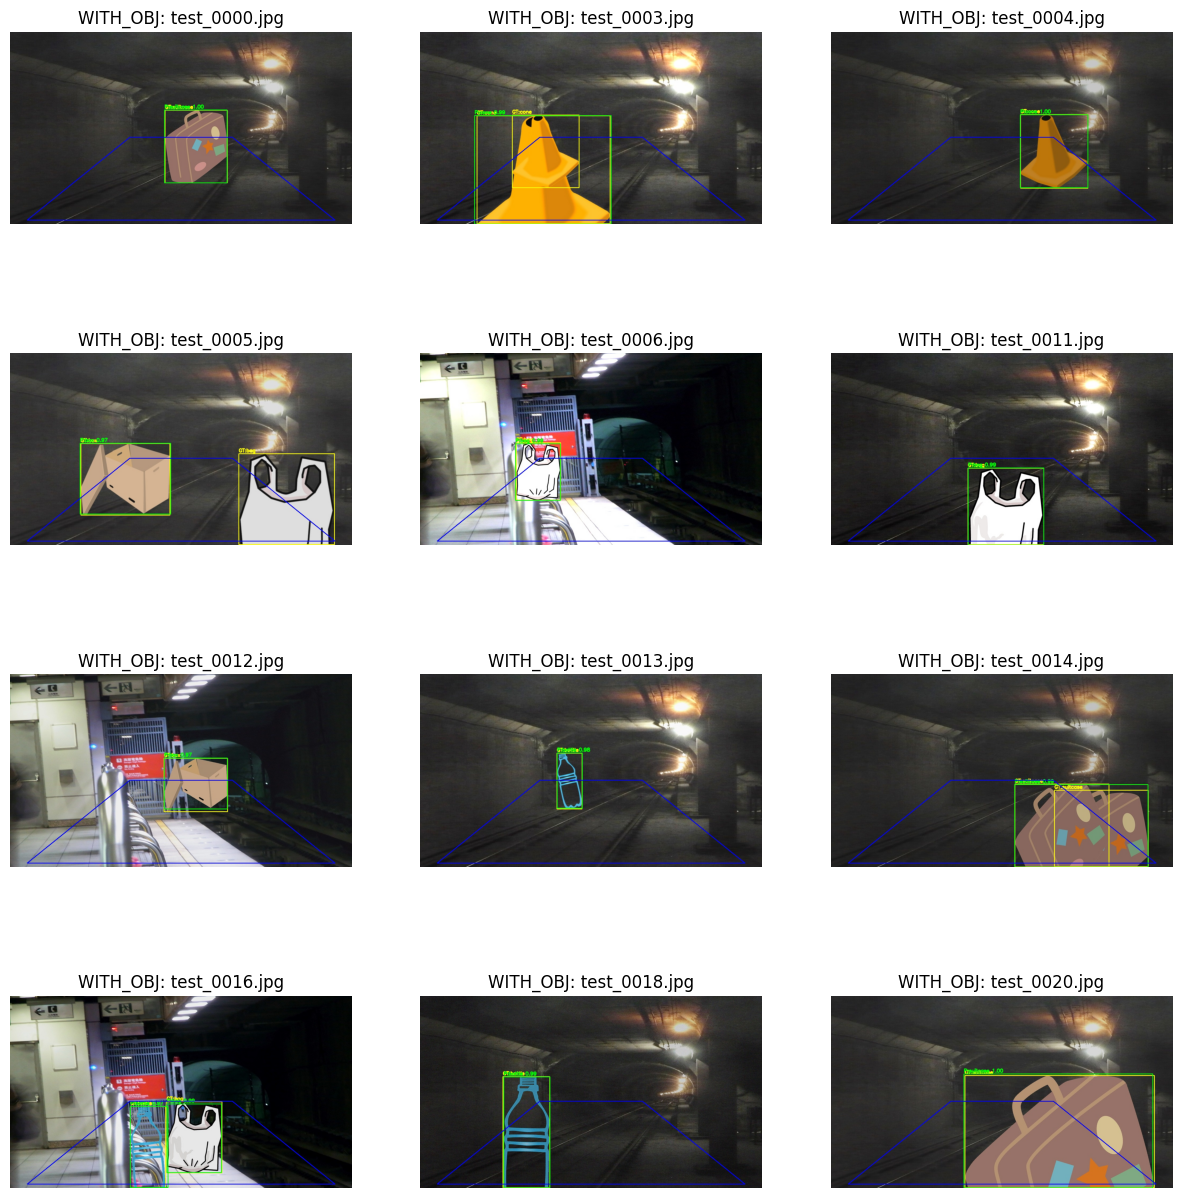

In [ ]:
annotated_list = sorted(list((ROOT/"outputs/with_objects_annotated").glob("*.jpg")))
print("Annotated with-object images:", len(annotated_list))

# 例如：一次看 12 张，翻页就改 start=0/12/24...
show_images_paged(annotated_list, title_prefix="WITH_OBJ: ", cols=3, start=0, n=12, draw_roi=False)


<font color="darkgreen" size="5">**- 可视化对比（同一张图 baseline vs yolo）**  <br>

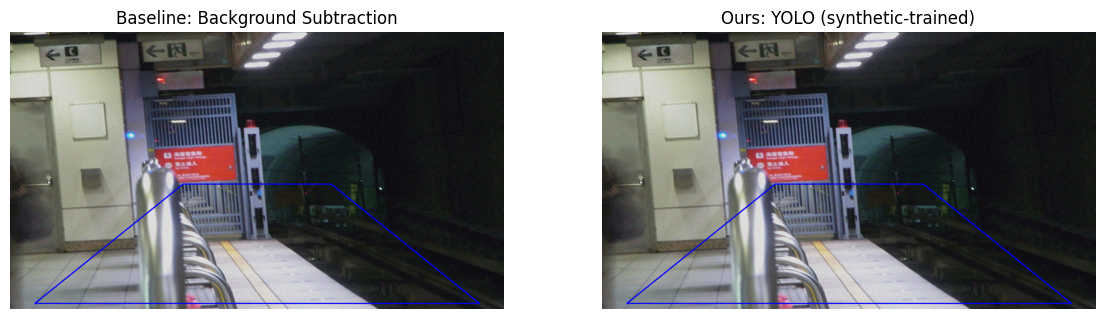

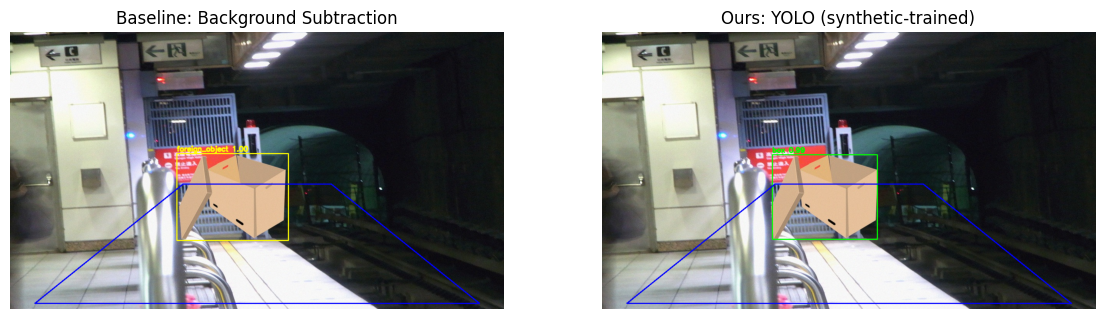

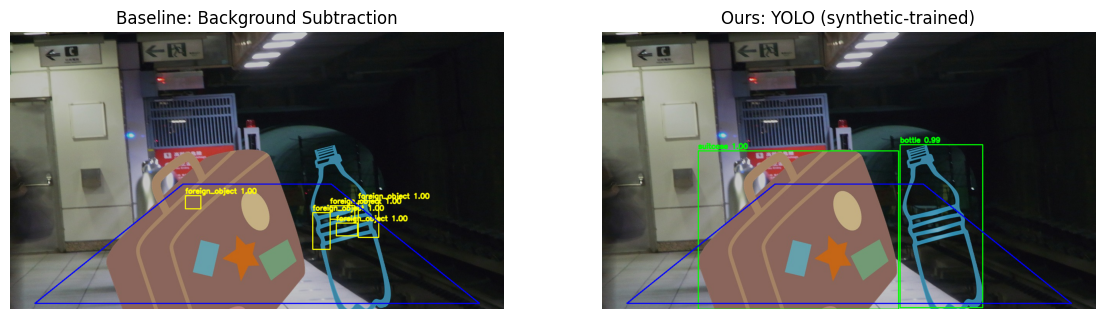

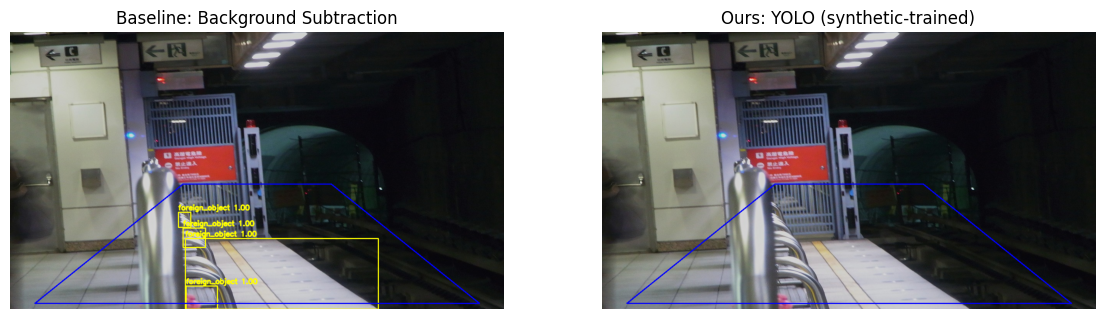

In [ ]:
sample = MANIFEST_TEST.sample(4, random_state=7)

for _,row in sample.iterrows():
    img_path = DATA/"images/test"/row["img"]
    img = cv2.imread(str(img_path))
    h,w = img.shape[:2]

    # baseline
    bg_path = CLEAN_BG_DIR/row["bg"]
    b_pred = baseline_bg_subtraction(img_path, bg_path, roi_gate=True)
    b_img = draw_boxes(img, [(0,bb,1.0) for _,bb,_ in b_pred], ["foreign_object"], color=(0,255,255))

    # yolo
    y_pred, _ = yolo_predict(img_path, conf=0.25, roi_gate=True)
    y_img = draw_boxes(img, y_pred, CLASS_NAMES, color=(0,255,0))

    # show ROI polygon
    poly = roi_poly(w,h)
    cv2.polylines(b_img, [poly], True, (255,0,0), 2)
    cv2.polylines(y_img, [poly], True, (255,0,0), 2)

    plt.figure(figsize=(14,6))
    plt.subplot(1,2,1); plt.title("Baseline: Background Subtraction"); plt.imshow(cv2.cvtColor(b_img, cv2.COLOR_BGR2RGB)); plt.axis("off")
    plt.subplot(1,2,2); plt.title("Ours: YOLO (synthetic-trained)"); plt.imshow(cv2.cvtColor(y_img, cv2.COLOR_BGR2RGB)); plt.axis("off")
    plt.show()



<font color="darkgreen" size="5">**- 检测→控制指令模拟（控制列车的动作）**  <br>


In [ ]:
def risk_score(box, conf, w, h):
    x0,y0,x1,y1 = box
    area = max(0,x1-x0)*max(0,y1-y0) / (w*h + 1e-9)
    # 离画面中心越近，权重越高（可替换为“到钢轨中心线距离”）
    cx = (x0+x1)/2 / w
    cy = (y0+y1)/2 / h
    center_dist = abs(cx-0.5)
    zone_w = 1.0 - min(0.9, center_dist/0.5) * 0.6
    return conf * area * zone_w

# 简单的“连续K帧稳定出现”逻辑（不用复杂跟踪也能演示）
class TemporalGate:
    def __init__(self, k=3):
        self.k = k
        self.count = 0
    def update(self, has_risky):
        self.count = self.count+1 if has_risky else 0
        return self.count >= self.k

def decide_command(dets, w, h, stop_th=0.015, slow_th=0.006):
    # dets: [(cid, box, conf)]
    if not dets:
        return None
    risks = [risk_score(b, c, w, h) for _,b,c in dets]
    rmax = max(risks)
    if rmax >= stop_th:
        return ("STOP", rmax)
    if rmax >= slow_th:
        return ("SLOW", rmax)
    return ("ALARM", rmax)

gate = TemporalGate(k=3)

# 用测试集随机抽取连续10张当“伪序列”
seq = MANIFEST_TEST.sample(10, random_state=1)

for t,(_,row) in enumerate(seq.iterrows()):
    img_path = DATA/"images/test"/row["img"]
    img = cv2.imread(str(img_path))
    h,w = img.shape[:2]

    dets, _ = yolo_predict(img_path, conf=0.25, roi_gate=True)
    cmd = decide_command(dets, w, h)

    has_risky = (cmd is not None and cmd[0] in ["STOP","SLOW"])
    stable = gate.update(has_risky)

    if cmd and stable:
        payload = {
            "ts": t,
            "camera_id": "CAM_DEMO_01",
            "command": cmd[0],
            "risk": float(cmd[1]),
            "detections": [
                {"cls": CLASS_NAMES[cid], "conf": float(conf), "box_xyxy": list(map(int, box))}
                for cid,box,conf in dets
            ]
        }
        print(">>> EMIT CONTROL EVENT:", json.dumps(payload, ensure_ascii=False))
    else:
        print(f"[t={t}] no stable high-risk event (dets={len(dets)})")


[t=0] no stable high-risk event (dets=0)
[t=1] no stable high-risk event (dets=0)
[t=2] no stable high-risk event (dets=1)
[t=3] no stable high-risk event (dets=0)
[t=4] no stable high-risk event (dets=0)
[t=5] no stable high-risk event (dets=0)
[t=6] no stable high-risk event (dets=0)
[t=7] no stable high-risk event (dets=1)
[t=8] no stable high-risk event (dets=2)
[t=9] no stable high-risk event (dets=0)




<font color="darkgreen" size="5">**- 对“有异物的图片”生成标注图（GT + Pred）并保存**  <br>

In [ ]:
import pandas as pd
import os, time, json
import cv2
import numpy as np
from pathlib import Path

OUT_DIR = ROOT/"outputs"
OUT_WITH = OUT_DIR/"with_objects_annotated"
OUT_GT   = OUT_DIR/"with_objects_gt_only"
OUT_PR   = OUT_DIR/"with_objects_pred_only"
for d in [OUT_WITH, OUT_GT, OUT_PR]:
    d.mkdir(parents=True, exist_ok=True)

MANIFEST_TEST = pd.read_csv(ROOT/"manifest_test.csv")

def yolo_labels_to_boxes(lbl_path, w, h):
    boxes=[]
    if not Path(lbl_path).exists():
        return boxes
    with open(lbl_path, "r") as f:
        for line in f:
            parts=line.strip().split()
            if len(parts)!=5:
                continue
            cid,cx,cy,bw,bh = int(parts[0]), *map(float, parts[1:])
            x0 = int((cx-bw/2)*w); x1 = int((cx+bw/2)*w)
            y0 = int((cy-bh/2)*h); y1 = int((cy+bh/2)*h)
            boxes.append((cid, (x0,y0,x1,y1)))
    return boxes

def point_in_roi(x,y,w,h):
    poly = roi_poly(w,h)
    return cv2.pointPolygonTest(poly, (float(x),float(y)), False) >= 0

def yolo_predict(img_path, conf=0.25, roi_gate=True):
    img = cv2.imread(str(img_path))
    h,w = img.shape[:2]
    t0 = time.perf_counter()
    preds = model.predict(str(img_path), imgsz=640, conf=conf, verbose=False)[0]
    t1 = time.perf_counter()

    boxes=[]
    for b in preds.boxes:
        cid = int(b.cls.item())
        confv = float(b.conf.item())
        x0,y0,x1,y1 = map(int, b.xyxy[0].tolist())
        cx,cy = (x0+x1)//2, (y0+y1)//2
        if roi_gate and (not point_in_roi(cx,cy,w,h)):
            continue
        boxes.append((cid,(x0,y0,x1,y1), confv))
    return boxes, (t1-t0)*1000.0

def draw_gt(img_bgr, gt_boxes, names, color=(0,255,255), thickness=2):
    out = img_bgr.copy()
    for cid,(x0,y0,x1,y1) in gt_boxes:
        cv2.rectangle(out, (x0,y0), (x1,y1), color, thickness)
        cv2.putText(out, f"GT:{names[cid]}", (x0, max(0,y0-6)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2, cv2.LINE_AA)
    return out

def draw_pred(img_bgr, pred_boxes, names, color=(0,255,0), thickness=2):
    out = img_bgr.copy()
    for cid,(x0,y0,x1,y1),conf in pred_boxes:
        cv2.rectangle(out, (x0,y0), (x1,y1), color, thickness)
        cv2.putText(out, f"P:{names[cid]} {conf:.2f}", (x0, max(0,y0-6)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2, cv2.LINE_AA)
    return out

with_obj_rows = MANIFEST_TEST[MANIFEST_TEST["has_obj"]==True].reset_index(drop=True)
print("Test images with objects:", len(with_obj_rows))

for _, row in tqdm(with_obj_rows.iterrows(), total=len(with_obj_rows), desc="Annotate with-obj"):
    img_path = DATA/"images/test"/row["img"]
    lbl_path = DATA/"labels/test"/row["img"].replace(".jpg",".txt")

    img = cv2.imread(str(img_path))
    h,w = img.shape[:2]

    # ROI 多边形
    poly = roi_poly(w,h)

    # GT
    gt = yolo_labels_to_boxes(lbl_path, w, h)

    # Pred
    pred, _ = yolo_predict(img_path, conf=0.25, roi_gate=True)

    # 只GT
    gt_img = draw_gt(img, gt, CLASS_NAMES, color=(0,255,255))
    cv2.polylines(gt_img, [poly], True, (255,0,0), 2)
    cv2.imwrite(str(OUT_GT/row["img"]), gt_img)

    # 只Pred
    pr_img = draw_pred(img, pred, CLASS_NAMES, color=(0,255,0))
    cv2.polylines(pr_img, [poly], True, (255,0,0), 2)
    cv2.imwrite(str(OUT_PR/row["img"]), pr_img)

    # GT + Pred
    both = draw_gt(img, gt, CLASS_NAMES, color=(0,255,255))
    both = draw_pred(both, pred, CLASS_NAMES, color=(0,255,0))
    cv2.polylines(both, [poly], True, (255,0,0), 2)
    cv2.imwrite(str(OUT_WITH/row["img"]), both)

print("Saved to:", OUT_WITH)


Test images with objects: 76


Annotate with-obj: 100%|██████████| 76/76 [00:03<00:00, 25.26it/s]

Saved to: /content/rail_foreign_object_exp/outputs/with_objects_annotated
